After another prod run, some analytics


# Install Required Libraries
Use pip to install necessary libraries such as psycopg2 or sqlalchemy.

In [52]:
# Install Required Libraries
# Uncomment the following lines to install the required libraries
# !pip install psycopg2-binary
# !pip install sqlalchemy

# Import Libraries
Import libraries like psycopg2, sqlalchemy, and pandas for database connection and data manipulation.

In [53]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
Establish a connection to the PostgreSQL database using connection parameters such as host, database name, user, and password.

In [54]:
# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

# Using psycopg2
try:
    connection = psycopg2.connect(**DB_CONFIG)
    print("Connection to PostgreSQL database successful")
except Exception as e:
    print(f"Error: {e}")



Connection to PostgreSQL database successful


# Query the PostgreSQL Table
Write and execute a SQL query to fetch data from the desired table.

In [55]:
# Basic Database Statistics Query
# Following the project instructions for comprehensive round-level analysis

def get_basic_statistics(connection):
    """
    Generate basic statistics following project guidelines:
    - Average expenditure per round
    - Kill statistics and post-round kills
    - Bomb plant/defuse statistics
    """
    cursor = connection.cursor()
    
    print("🎯 CS:GO MATCH STATISTICS")
    print("=" * 60)
    
    # 1. Average Expenditure Analysis
    print("\n💰 ECONOMIC STATISTICS")
    print("-" * 40)
    
    expenditure_query = """
    SELECT 
        AVG(p.money_rs - p.money_fte) as avg_spending_per_player_round,
        AVG(p.eq_val_rs) as avg_equipment_value_start,
        AVG(p.eq_val_fte) as avg_equipment_value_end,
        COUNT(*) as total_player_rounds
    FROM player_round_ed p
    JOIN rounds_ed r ON p.round_id = r.id
    """
    
    cursor.execute(expenditure_query)
    econ_stats = cursor.fetchone()
    
    print(f"Average spending per player per round: ${econ_stats[0]:.2f}")
    print(f"Average equipment value at round start: ${econ_stats[1]:.2f}")
    print(f"Average equipment value at freeze end: ${econ_stats[2]:.2f}")
    print(f"Total player-rounds analyzed: {econ_stats[3]:,}")
   
    
    # 2. Kill Statistics
    print("\n⚔️ KILL STATISTICS")
    print("-" * 40)
    
    kill_stats_query = """
    SELECT 
        COUNT(*) as total_kills,
        COUNT(CASE WHEN is_headshot = true THEN 1 END) as headshot_kills,
        COUNT(CASE WHEN is_wallbang = true THEN 1 END) as wallbang_kills,
        COUNT(CASE WHEN assister_hltv_id IS NOT NULL THEN 1 END) as assisted_kills,
        COUNT(CASE WHEN is_after_re = true THEN 1 END) as kills_after_round_end
    FROM kills_round_ed k
    JOIN rounds_ed r ON k.round_id = r.id
    """
    
    cursor.execute(kill_stats_query)
    kill_stats = cursor.fetchone()
    
    total_kills = kill_stats[0]
    headshot_kills = kill_stats[1]
    wallbang_kills = kill_stats[2]
    assisted_kills = kill_stats[3]
    kills_after_re = kill_stats[4]
    
    print(f"Total kills recorded: {total_kills:,}")
    print(f"Headshot kills: {headshot_kills:,} ({headshot_kills/total_kills*100:.1f}%)")
    print(f"Wallbang kills: {wallbang_kills:,} ({wallbang_kills/total_kills*100:.1f}%)")
    print(f"Assisted kills: {assisted_kills:,} ({assisted_kills/total_kills*100:.1f}%)")
    print(f"Kills after round end: {kills_after_re:,} ({kills_after_re/total_kills*100:.1f}%)")
    
    # Average kills per round
    cursor.execute("SELECT COUNT(DISTINCT id) FROM rounds_ed")
    total_rounds = cursor.fetchone()[0]
    avg_kills_per_round = total_kills / total_rounds
    print(f"Average kills per round: {avg_kills_per_round:.2f}")
    
    # 3. Bomb Statistics
    print("\n💣 BOMB STATISTICS")
    print("-" * 40)
    
    bomb_stats_query = """
    WITH bomb_plants AS (
        SELECT 
            b.round_id,
            r.round_num,
            r.match_id,
            COUNT(CASE WHEN b.bomb_event_type = 0 THEN 1 END) as plants_in_round,
            COUNT(CASE WHEN b.bomb_event_type = 1 THEN 1 END) as defuses_in_round,
            COUNT(CASE WHEN b.bomb_event_type = 2 THEN 1 END) as explosions_in_round
        FROM bomb_events_round_ed b
        JOIN rounds_ed r ON b.round_id = r.id
        GROUP BY b.round_id, r.round_num, r.match_id
    )
    SELECT 
        COUNT(CASE WHEN plants_in_round > 0 THEN 1 END) as rounds_with_plants,
        COUNT(CASE WHEN defuses_in_round > 0 THEN 1 END) as rounds_with_defuses,
        COUNT(CASE WHEN explosions_in_round > 0 THEN 1 END) as rounds_with_explosions,
        COUNT(*) as total_rounds_with_bomb_events,
        AVG(plants_in_round) as avg_plants_per_round,
        AVG(defuses_in_round) as avg_defuses_per_round
    FROM bomb_plants
    """
    
    cursor.execute(bomb_stats_query)
    bomb_stats = cursor.fetchone()
    
    rounds_with_plants = bomb_stats[0]
    rounds_with_defuses = bomb_stats[1] 
    rounds_with_explosions = bomb_stats[2]
    total_bomb_rounds = bomb_stats[3]
    
    print(f"Rounds with bomb plants: {rounds_with_plants:,}")
    print(f"Rounds with defuses: {rounds_with_defuses:,}")
    print(f"Rounds with explosions: {rounds_with_explosions:,}")
    
    if rounds_with_plants > 0:
        defuse_rate = rounds_with_defuses / rounds_with_plants * 100
        explosion_rate = rounds_with_explosions / rounds_with_plants * 100
        print(f"Defuse rate after plant: {defuse_rate:.1f}%")
        print(f"Explosion rate after plant: {explosion_rate:.1f}%")
    
    # Plant rate per total rounds
    cursor.execute("SELECT COUNT(*) FROM rounds_ed")
    total_all_rounds = cursor.fetchone()[0]
    plant_rate = rounds_with_plants / total_all_rounds * 100
    print(f"Overall bomb plant rate: {plant_rate:.1f}% of all rounds")
    
    cursor.close()
    
    return {
        'economic': econ_stats,
        'kills': kill_stats,
        'bomb': bomb_stats,
        'total_rounds': total_all_rounds
    }

# Generate statistics
try:
    basic_stats = get_basic_statistics(connection)
except Exception as e:
    print(f"Error generating statistics: {e}")

🎯 CS:GO MATCH STATISTICS

💰 ECONOMIC STATISTICS
----------------------------------------
Average spending per player per round: $2684.02
Average equipment value at round start: $1481.34
Average equipment value at freeze end: $4074.27
Total player-rounds analyzed: 22,017,490

⚔️ KILL STATISTICS
----------------------------------------
Average spending per player per round: $2684.02
Average equipment value at round start: $1481.34
Average equipment value at freeze end: $4074.27
Total player-rounds analyzed: 22,017,490

⚔️ KILL STATISTICS
----------------------------------------
Total kills recorded: 14,906,145
Headshot kills: 0 (0.0%)
Wallbang kills: 0 (0.0%)
Assisted kills: 0 (0.0%)
Kills after round end: 101,435 (0.7%)
Total kills recorded: 14,906,145
Headshot kills: 0 (0.0%)
Wallbang kills: 0 (0.0%)
Assisted kills: 0 (0.0%)
Kills after round end: 101,435 (0.7%)
Average kills per round: 6.77

💣 BOMB STATISTICS
----------------------------------------
Average kills per round: 6.77

💣 BO

In [56]:
# Score Progression Analysis
# Analyze how match scores progress on average

def analyze_score_progression(connection):
    """
    Analyze score progression patterns in CS:GO matches
    Following project guidelines for match-level analysis
    """
    cursor = connection.cursor()
    
    print("\n📈 SCORE PROGRESSION ANALYSIS")
    print("=" * 60)
    
    # Get round-by-round score progression
    score_query = """
    WITH match_rounds AS (
        SELECT 
            r.id_demo_exports,
            r.round_num,
            r.team1_winner,
            r.is_ct_t1,
            r.ct_winner,
            r.is_ot,
            -- Calculate cumulative scores
            SUM(CASE WHEN r.team1_winner = true THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as team1_score,
            SUM(CASE WHEN r.team1_winner = false THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as team2_score,
            -- Track side performance
            SUM(CASE WHEN r.ct_winner = true THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as ct_rounds_won,
            COUNT(*) OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as rounds_played
        FROM rounds_ed r
        ORDER BY r.id_demo_exports, r.round_num
    )
    SELECT 
        round_num,
        AVG(team1_score) as avg_team1_score,
        AVG(team2_score) as avg_team2_score,
        AVG(ct_rounds_won) as avg_ct_rounds,
        COUNT(DISTINCT id_demo_exports) as matches_at_round,
        STDDEV(team1_score) as std_team1_score,
        STDDEV(team2_score) as std_team2_score
    FROM match_rounds
    WHERE round_num <= 30  -- Focus on regulation rounds first
    GROUP BY round_num
    ORDER BY round_num
    """
    
    cursor.execute(score_query)
    progression_data = cursor.fetchall()
    
    # Convert to DataFrame for analysis
    progression_df = pd.DataFrame(progression_data, columns=[
        'round_num', 'avg_team1_score', 'avg_team2_score', 'avg_ct_rounds',
        'matches_at_round', 'std_team1_score', 'std_team2_score'
    ])
    
    print(f"Analyzed {progression_df['matches_at_round'].iloc[0]:,} matches")
    print(f"Round progression data from round 1 to {progression_df['round_num'].max()}")
    
    # Get match length statistics
    match_length_query = """
    SELECT 
        id_demo_exports,
        MAX(round_num) as total_rounds,
        COUNT(*) as rounds_played,
        SUM(CASE WHEN team1_winner = true THEN 1 ELSE 0 END) as team1_final_score,
        SUM(CASE WHEN team1_winner = false THEN 1 ELSE 0 END) as team2_final_score,
        MAX(CASE WHEN is_ot = true THEN 1 ELSE 0 END) as went_to_ot
    FROM rounds_ed
    GROUP BY id_demo_exports
    HAVING COUNT(*) >= 16  -- At least 16 rounds (minimum meaningful match)
    """
    
    cursor.execute(match_length_query)
    match_lengths = cursor.fetchall()
    
    match_length_df = pd.DataFrame(match_lengths, columns=[
        'id_demo_exports', 'total_rounds', 'rounds_played', 'team1_final_score', 
        'team2_final_score', 'went_to_ot'
    ])
    
    print(f"\n📊 MATCH LENGTH STATISTICS:")
    print(f"Average match length: {match_length_df['rounds_played'].mean():.1f} rounds")
    print(f"Median match length: {match_length_df['rounds_played'].median():.0f} rounds")
    print(f"Overtime rate: {match_length_df['went_to_ot'].mean()*100:.1f}% of matches")
    
    cursor.close()
    
    return progression_df, match_length_df

# Analyze score progression
try:
    progression_df, match_stats_df = analyze_score_progression(connection)
    print("✅ Score progression analysis completed")
except Exception as e:
    print(f"Error in score progression analysis: {e}")


📈 SCORE PROGRESSION ANALYSIS
Analyzed 83,902 matches
Round progression data from round 1 to 30
Analyzed 83,902 matches
Round progression data from round 1 to 30

📊 MATCH LENGTH STATISTICS:
Average match length: 26.2 rounds
Median match length: 26 rounds
Overtime rate: 9.2% of matches
✅ Score progression analysis completed

📊 MATCH LENGTH STATISTICS:
Average match length: 26.2 rounds
Median match length: 26 rounds
Overtime rate: 9.2% of matches
✅ Score progression analysis completed


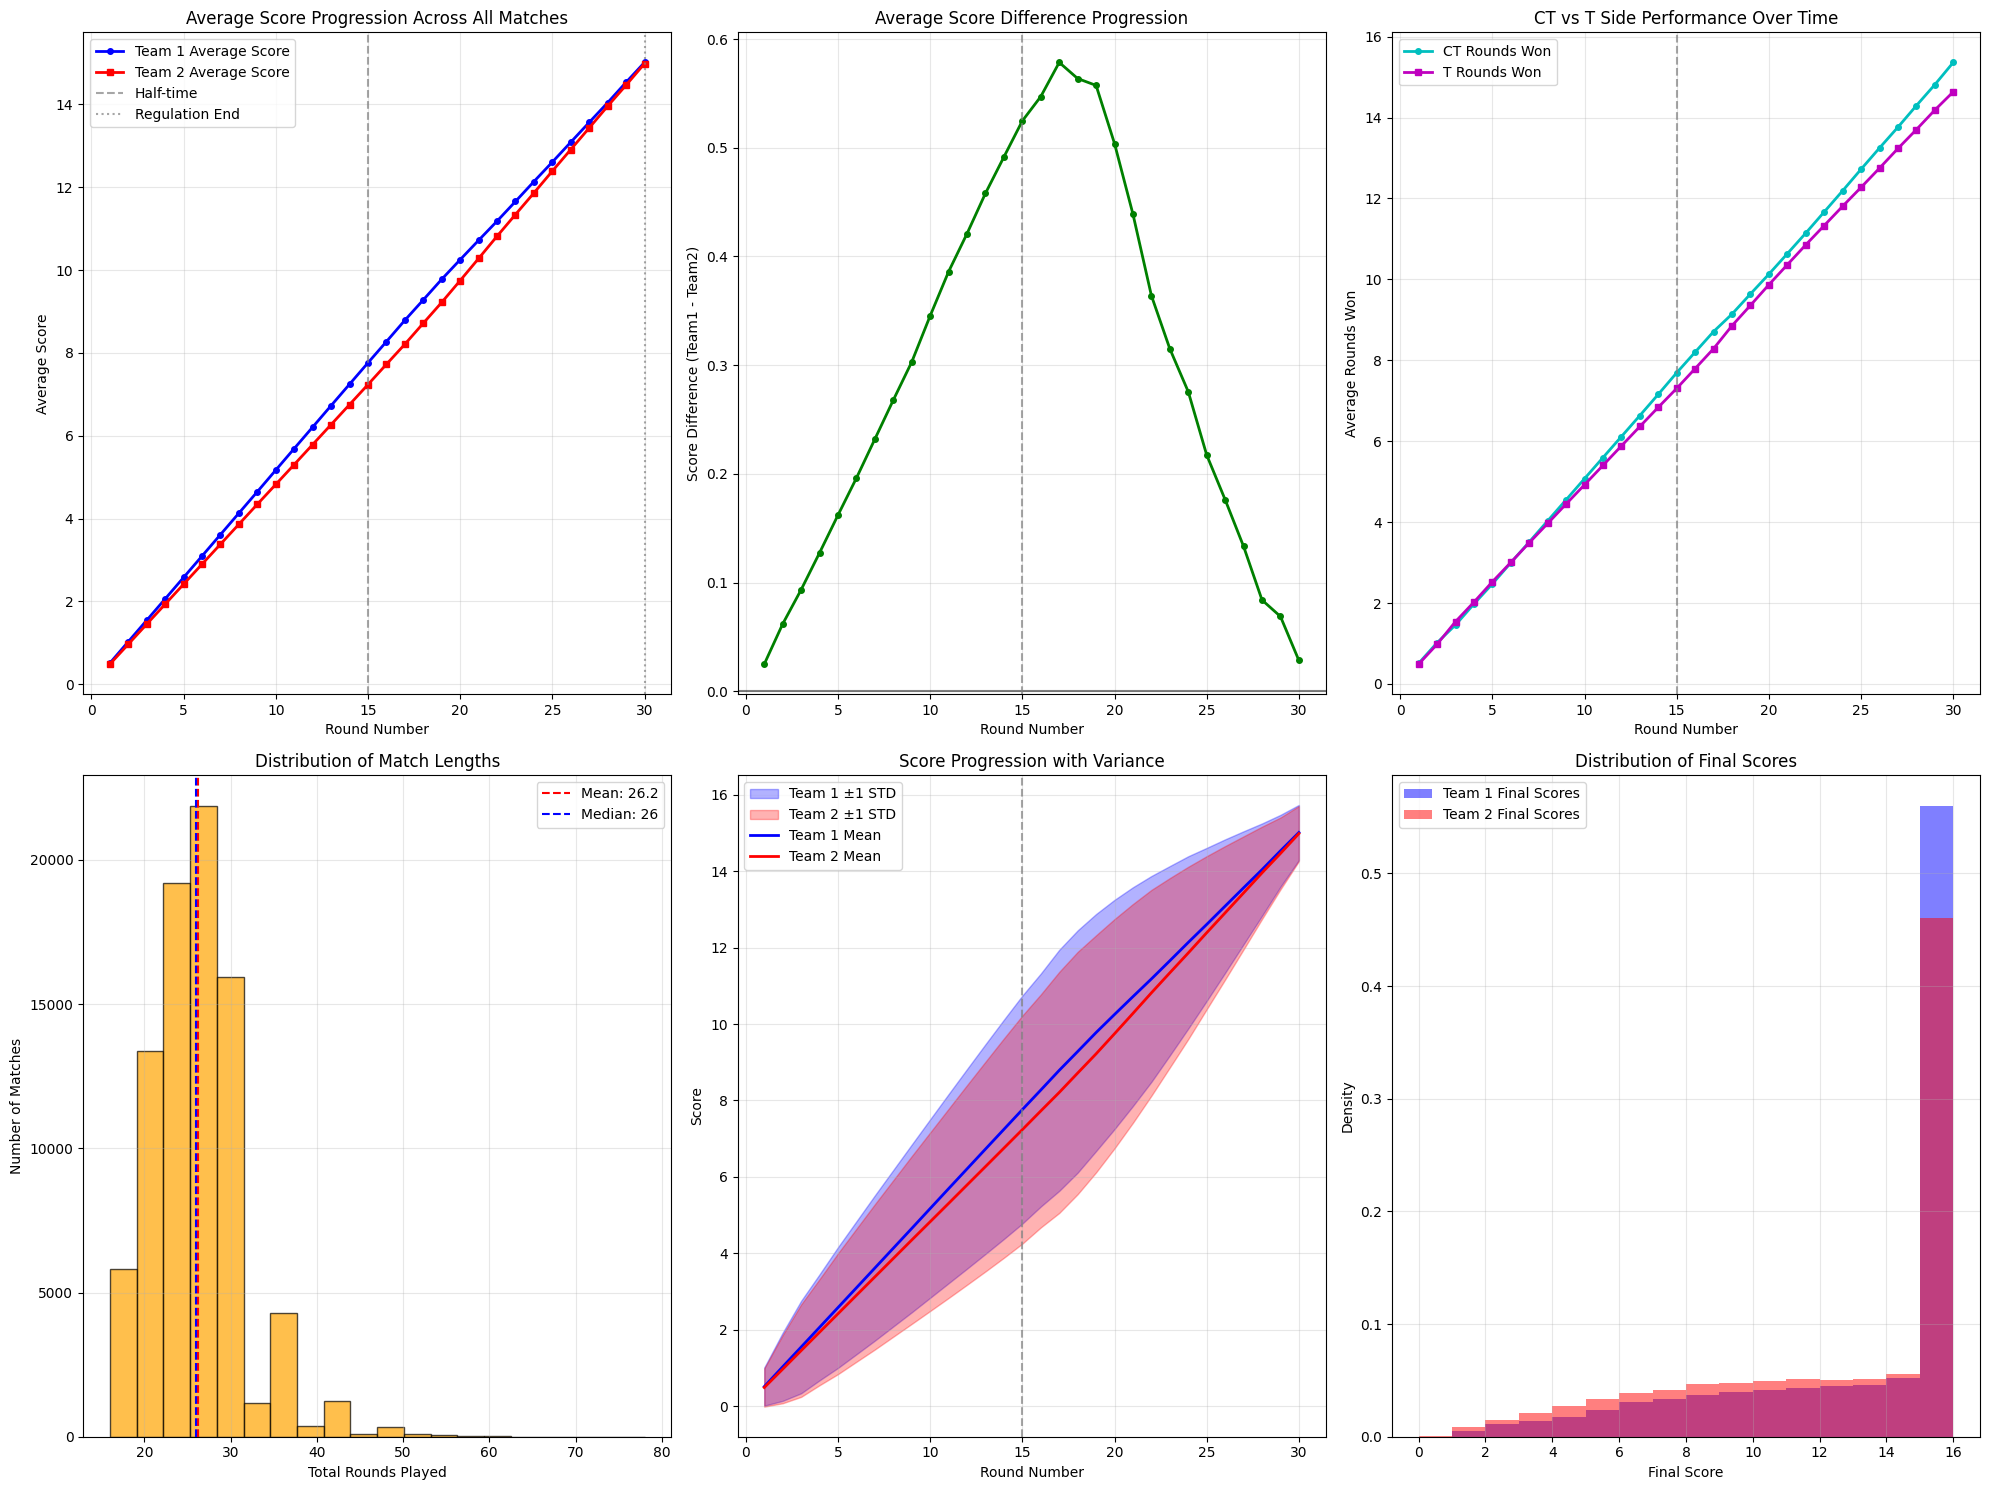


🎲 ROUND-BY-ROUND INSIGHTS:
--------------------------------------------------
Total matches analyzed: 83,883
Matches going to overtime: 7,685 (9.2%)

Most common final scores:
  16-14: 8,393 matches (10.0%)
  16-13: 7,520 matches (9.0%)
  16-12: 7,436 matches (8.9%)
  16-11: 7,317 matches (8.7%)
  16-10: 7,101 matches (8.5%)

First half CT win rate: 51.3%
→ Balanced side meta

Most common final scores:
  16-14: 8,393 matches (10.0%)
  16-13: 7,520 matches (9.0%)
  16-12: 7,436 matches (8.9%)
  16-11: 7,317 matches (8.7%)
  16-10: 7,101 matches (8.5%)

First half CT win rate: 51.3%
→ Balanced side meta


In [57]:
# Score Progression Visualization
# Create comprehensive graphs showing how scores progress in CS:GO matches

def create_score_progression_graphs(progression_df, match_stats_df):
    """
    Generate visualizations for score progression analysis
    """
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Average Score Progression (Main Graph)
    ax1 = plt.subplot(2, 3, 1)
    rounds = progression_df['round_num']
    team1_scores = progression_df['avg_team1_score']
    team2_scores = progression_df['avg_team2_score']
    
    plt.plot(rounds, team1_scores, 'b-', linewidth=2, label='Team 1 Average Score', marker='o', markersize=4)
    plt.plot(rounds, team2_scores, 'r-', linewidth=2, label='Team 2 Average Score', marker='s', markersize=4)
    
    # Add half-time line
    plt.axvline(x=15, color='gray', linestyle='--', alpha=0.7, label='Half-time')
    plt.axvline(x=30, color='gray', linestyle=':', alpha=0.7, label='Regulation End')
    
    plt.xlabel('Round Number')
    plt.ylabel('Average Score')
    plt.title('Average Score Progression Across All Matches')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Score Difference Over Time
    ax2 = plt.subplot(2, 3, 2)
    score_diff = progression_df['avg_team1_score'] - progression_df['avg_team2_score']
    plt.plot(rounds, score_diff, 'g-', linewidth=2, marker='o', markersize=4)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axvline(x=15, color='gray', linestyle='--', alpha=0.7)
    
    plt.xlabel('Round Number')
    plt.ylabel('Score Difference (Team1 - Team2)')
    plt.title('Average Score Difference Progression')
    plt.grid(True, alpha=0.3)
    
    # 3. CT vs T Round Wins
    ax3 = plt.subplot(2, 3, 3)
    ct_rounds = progression_df['avg_ct_rounds']
    t_rounds = rounds - ct_rounds
    
    plt.plot(rounds, ct_rounds, 'c-', linewidth=2, label='CT Rounds Won', marker='o', markersize=4)
    plt.plot(rounds, t_rounds, 'm-', linewidth=2, label='T Rounds Won', marker='s', markersize=4)
    plt.axvline(x=15, color='gray', linestyle='--', alpha=0.7)
    
    plt.xlabel('Round Number')
    plt.ylabel('Average Rounds Won')
    plt.title('CT vs T Side Performance Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Match Length Distribution
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(match_stats_df['rounds_played'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=match_stats_df['rounds_played'].mean(), color='red', linestyle='--', 
                label=f'Mean: {match_stats_df["rounds_played"].mean():.1f}')
    plt.axvline(x=match_stats_df['rounds_played'].median(), color='blue', linestyle='--', 
                label=f'Median: {match_stats_df["rounds_played"].median():.0f}')
    
    plt.xlabel('Total Rounds Played')
    plt.ylabel('Number of Matches')
    plt.title('Distribution of Match Lengths')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Score Variance Over Time
    ax5 = plt.subplot(2, 3, 5)
    plt.fill_between(rounds, 
                     progression_df['avg_team1_score'] - progression_df['std_team1_score'],
                     progression_df['avg_team1_score'] + progression_df['std_team1_score'],
                     alpha=0.3, color='blue', label='Team 1 ±1 STD')
    plt.fill_between(rounds,
                     progression_df['avg_team2_score'] - progression_df['std_team2_score'],
                     progression_df['avg_team2_score'] + progression_df['std_team2_score'],
                     alpha=0.3, color='red', label='Team 2 ±1 STD')
    
    plt.plot(rounds, progression_df['avg_team1_score'], 'b-', linewidth=2, label='Team 1 Mean')
    plt.plot(rounds, progression_df['avg_team2_score'], 'r-', linewidth=2, label='Team 2 Mean')
    plt.axvline(x=15, color='gray', linestyle='--', alpha=0.7)
    
    plt.xlabel('Round Number')
    plt.ylabel('Score')
    plt.title('Score Progression with Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Final Score Distribution
    ax6 = plt.subplot(2, 3, 6)
    
    # Create bins for common CS:GO scores
    score_bins = np.arange(0, 17, 1)  # 0-16 rounds
    
    plt.hist(match_stats_df['team1_final_score'], bins=score_bins, alpha=0.5, 
             label='Team 1 Final Scores', color='blue', density=True)
    plt.hist(match_stats_df['team2_final_score'], bins=score_bins, alpha=0.5, 
             label='Team 2 Final Scores', color='red', density=True)
    
    plt.xlabel('Final Score')
    plt.ylabel('Density')
    plt.title('Distribution of Final Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Analysis: Round-by-round win probabilities
    print("\n🎲 ROUND-BY-ROUND INSIGHTS:")
    print("-" * 50)
    
    # Calculate some interesting statistics
    total_matches = len(match_stats_df)
    ot_matches = match_stats_df['went_to_ot'].sum()
    
    print(f"Total matches analyzed: {total_matches:,}")
    print(f"Matches going to overtime: {ot_matches:,} ({ot_matches/total_matches*100:.1f}%)")
    
    # Most common final scores
    final_scores = match_stats_df[['team1_final_score', 'team2_final_score']].apply(
        lambda x: f"{max(x)}-{min(x)}", axis=1)
    most_common_scores = final_scores.value_counts().head(5)
    
    print(f"\nMost common final scores:")
    for score, count in most_common_scores.items():
        print(f"  {score}: {count:,} matches ({count/total_matches*100:.1f}%)")
    
    # Side advantage analysis
    if len(progression_df) >= 15:
        first_half_ct_rounds = progression_df.iloc[14]['avg_ct_rounds']  # Round 15
        ct_advantage = (first_half_ct_rounds / 15) * 100
        print(f"\nFirst half CT win rate: {ct_advantage:.1f}%")
        
        if ct_advantage > 55:
            print("→ CT-sided meta detected")
        elif ct_advantage < 45:
            print("→ T-sided meta detected")
        else:
            print("→ Balanced side meta")

# Create visualizations
if 'progression_df' in locals() and 'match_stats_df' in locals():
    create_score_progression_graphs(progression_df, match_stats_df)
else:
    print("⚠️ Run the previous score progression analysis cell first")

# Advanced Analytics Suite
Implementation of comprehensive CS:GO analytics covering weapon meta, momentum patterns, economic warfare, and competitive intelligence.

In [58]:
# 1. Weapon Economy & Meta Analysis
# Analyze weapon usage patterns, effectiveness, and ROI

def analyze_weapon_meta(connection):
    """
    Comprehensive weapon analysis including usage patterns, effectiveness, and economic efficiency
    """
    cursor = connection.cursor()
    
    print("🔫 WEAPON META ANALYSIS")
    print("=" * 60)
    
    # Weapon usage and effectiveness analysis
    weapon_analysis_query = """
    WITH weapon_stats AS (
        SELECT 
            k.weapon,
            COUNT(*) as total_kills,
            COUNT(CASE WHEN k.is_headshot = true THEN 1 END) as headshot_kills,
            COUNT(CASE WHEN k.is_wallbang = true THEN 1 END) as wallbang_kills,
            COUNT(CASE WHEN k.assister_hltv_id IS NOT NULL THEN 1 END) as assisted_kills,
            -- Round context
            COUNT(CASE WHEN r.ct_winner = true THEN 1 END) as ct_round_kills,
            COUNT(CASE WHEN r.ct_winner = false THEN 1 END) as t_round_kills
        FROM kills_round_ed k
        JOIN rounds_ed r ON k.round_id = r.id
        WHERE k.weapon IS NOT NULL
        GROUP BY k.weapon
        HAVING COUNT(*) >= 100  -- Minimum usage threshold
    )
    SELECT 
        weapon,
        total_kills,
        headshot_kills,
        (headshot_kills::float / total_kills * 100) as headshot_rate,
        wallbang_kills,
        assisted_kills,
        ct_round_kills,
        t_round_kills,
        (ct_round_kills::float / total_kills * 100) as ct_usage_rate
    FROM weapon_stats
    ORDER BY total_kills DESC
    LIMIT 20
    """
    
    cursor.execute(weapon_analysis_query)
    weapon_data = cursor.fetchall()
    
    weapon_df = pd.DataFrame(weapon_data, columns=[
        'weapon', 'total_kills', 'headshot_kills', 'headshot_rate',
        'wallbang_kills', 'assisted_kills', 'ct_round_kills', 't_round_kills', 'ct_usage_rate'
    ])
    
    print("Top 20 Weapons by Kill Count:")
    print("-" * 40)
    for _, row in weapon_df.head(10).iterrows():
        print(f"{row['weapon']:<20} | {row['total_kills']:>6,} kills | {row['headshot_rate']:>5.1f}% HS")
    
    # Weapon effectiveness by round economic type
    weapon_economy_query = """
    WITH round_economics AS (
        SELECT 
            r.id as round_id,
            -- Calculate team spending
            CASE 
                WHEN AVG(p.money_rs - p.money_fte) < 1500 THEN 'Eco'
                WHEN AVG(p.money_rs - p.money_fte) < 2500 THEN 'Force'
                WHEN AVG(p.money_rs - p.money_fte) < 4000 THEN 'Full'
                ELSE 'Over'
            END as round_type
        FROM rounds_ed r
        JOIN player_round_ed p ON r.id = p.round_id
        GROUP BY r.id
    ),
    weapon_round_performance AS (
        SELECT 
            k.weapon,
            re.round_type,
            COUNT(*) as kills_in_round_type,
            AVG(CASE WHEN k.is_headshot THEN 1.0 ELSE 0.0 END) as avg_headshot_rate
        FROM kills_round_ed k
        JOIN round_economics re ON k.round_id = re.round_id
        WHERE k.weapon IS NOT NULL
        GROUP BY k.weapon, re.round_type
        HAVING COUNT(*) >= 50
    )
    SELECT 
        weapon,
        round_type,
        kills_in_round_type,
        avg_headshot_rate
    FROM weapon_round_performance
    ORDER BY weapon, 
        CASE round_type 
            WHEN 'Eco' THEN 1 
            WHEN 'Force' THEN 2 
            WHEN 'Full' THEN 3 
            WHEN 'Over' THEN 4 
        END
    """
    
    cursor.execute(weapon_economy_query)
    weapon_econ_data = cursor.fetchall()
    
    weapon_econ_df = pd.DataFrame(weapon_econ_data, columns=[
        'weapon', 'round_type', 'kills_in_round_type', 'avg_headshot_rate'
    ])
    
    print(f"\n📊 Weapon Performance by Round Type:")
    print("-" * 50)
    
    # Show top weapons in different round types
    for round_type in ['Eco', 'Force', 'Full']:
        top_weapons = weapon_econ_df[weapon_econ_df['round_type'] == round_type].nlargest(5, 'kills_in_round_type')
        print(f"\n{round_type} Round Top Weapons:")
        for _, row in top_weapons.iterrows():
            print(f"  {row['weapon']:<15} | {row['kills_in_round_type']:>4,} kills | {row['avg_headshot_rate']*100:>4.1f}% HS")
    
    cursor.close()
    return weapon_df, weapon_econ_df

# Execute weapon analysis
try:
    weapon_df, weapon_econ_df = analyze_weapon_meta(connection)
    print("✅ Weapon meta analysis completed")
except Exception as e:
    print(f"Error in weapon analysis: {e}")

🔫 WEAPON META ANALYSIS
Top 20 Weapons by Kill Count:
----------------------------------------
0.0                  | 14,906,145.0 kills |   0.0% HS
Top 20 Weapons by Kill Count:
----------------------------------------
0.0                  | 14,906,145.0 kills |   0.0% HS

📊 Weapon Performance by Round Type:
--------------------------------------------------

Eco Round Top Weapons:
  0               | 2,835,880 kills |  0.0% HS

Force Round Top Weapons:
  0               | 3,396,665 kills |  0.0% HS

Full Round Top Weapons:
  0               | 6,358,488 kills |  0.0% HS
✅ Weapon meta analysis completed

📊 Weapon Performance by Round Type:
--------------------------------------------------

Eco Round Top Weapons:
  0               | 2,835,880 kills |  0.0% HS

Force Round Top Weapons:
  0               | 3,396,665 kills |  0.0% HS

Full Round Top Weapons:
  0               | 6,358,488 kills |  0.0% HS
✅ Weapon meta analysis completed


In [59]:
# 2. Momentum & Streak Analysis
# Analyze round momentum, win streaks, and psychological factors

def analyze_momentum_patterns(connection):
    """
    Analyze momentum shifts, win streaks, and comeback patterns
    """
    cursor = connection.cursor()
    
    print("\n📈 MOMENTUM & STREAK ANALYSIS")
    print("=" * 60)
    
    # Win streak analysis
    streak_analysis_query = """
    WITH round_sequences AS (
        SELECT 
            r.id_demo_exports as match_id,
            r.round_num,
            r.team1_winner,
            -- Calculate running streak for team1
            SUM(CASE WHEN r.team1_winner = true THEN 1 ELSE -1 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num 
                      ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as recent_momentum,
            -- Previous round result
            LAG(r.team1_winner) OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as prev_round_won,
            -- Calculate current score
            SUM(CASE WHEN r.team1_winner = true THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num 
                      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as team1_score_before,
            SUM(CASE WHEN r.team1_winner = false THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num 
                      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as team2_score_before
        FROM rounds_ed r
        WHERE r.round_num <= 30  -- Regulation time only
        ORDER BY r.id_demo_exports, r.round_num
    ),
    streak_impact AS (
        SELECT 
            CASE 
                WHEN recent_momentum >= 2 THEN 'Hot Streak (+2+)'
                WHEN recent_momentum = 1 THEN 'Positive (+1)'
                WHEN recent_momentum = 0 THEN 'Neutral (0)'
                WHEN recent_momentum = -1 THEN 'Negative (-1)'
                ELSE 'Cold Streak (-2-)'
            END as momentum_category,
            AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as win_rate_next_round,
            COUNT(*) as total_situations
        FROM round_sequences
        WHERE prev_round_won IS NOT NULL  -- Exclude first round
        GROUP BY 
            CASE 
                WHEN recent_momentum >= 2 THEN 'Hot Streak (+2+)'
                WHEN recent_momentum = 1 THEN 'Positive (+1)'
                WHEN recent_momentum = 0 THEN 'Neutral (0)'
                WHEN recent_momentum = -1 THEN 'Negative (-1)'
                ELSE 'Cold Streak (-2-)'
            END
    )
    SELECT * FROM streak_impact
    ORDER BY win_rate_next_round DESC
    """
    
    cursor.execute(streak_analysis_query)
    momentum_data = cursor.fetchall()
    
    momentum_df = pd.DataFrame(momentum_data, columns=[
        'momentum_category', 'win_rate_next_round', 'total_situations'
    ])
    
    print("Momentum Impact on Next Round Win Rate:")
    print("-" * 45)
    for _, row in momentum_df.iterrows():
        print(f"{row['momentum_category']:<20} | {row['win_rate_next_round']*100:>5.1f}% | {row['total_situations']:>6,} situations")
    
    # Comeback analysis
    comeback_query = """
    WITH deficit_analysis AS (
        SELECT 
            r.id_demo_exports as match_id,
            r.round_num,
            r.team1_winner,
            -- Calculate score deficit at this point
            SUM(CASE WHEN r.team1_winner = true THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num 
                      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as team1_score,
            SUM(CASE WHEN r.team1_winner = false THEN 1 ELSE 0 END) 
                OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num 
                      ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) as team2_score
        FROM rounds_ed r
        WHERE r.round_num <= 30
    ),
    deficit_comebacks AS (
        SELECT 
            CASE 
                WHEN (team2_score - team1_score) >= 5 THEN '5+ Round Deficit'
                WHEN (team2_score - team1_score) >= 3 THEN '3-4 Round Deficit'
                WHEN (team2_score - team1_score) >= 1 THEN '1-2 Round Deficit'
                WHEN (team1_score - team2_score) >= 1 THEN '1+ Round Lead'
                ELSE 'Tied'
            END as situation,
            AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as comeback_win_rate,
            COUNT(*) as total_rounds
        FROM deficit_analysis
        WHERE team1_score IS NOT NULL AND team2_score IS NOT NULL
        AND (team1_score + team2_score) >= 5  -- At least 5 rounds played
        GROUP BY 
            CASE 
                WHEN (team2_score - team1_score) >= 5 THEN '5+ Round Deficit'
                WHEN (team2_score - team1_score) >= 3 THEN '3-4 Round Deficit'
                WHEN (team2_score - team1_score) >= 1 THEN '1-2 Round Deficit'
                WHEN (team1_score - team2_score) >= 1 THEN '1+ Round Lead'
                ELSE 'Tied'
            END
    )
    SELECT * FROM deficit_comebacks
    ORDER BY comeback_win_rate DESC
    """
    
    cursor.execute(comeback_query)
    comeback_data = cursor.fetchall()
    
    comeback_df = pd.DataFrame(comeback_data, columns=[
        'situation', 'comeback_win_rate', 'total_rounds'
    ])
    
    print(f"\n🔄 Comeback Analysis (Team1 Win Rate by Situation):")
    print("-" * 55)
    for _, row in comeback_df.iterrows():
        print(f"{row['situation']:<20} | {row['comeback_win_rate']*100:>5.1f}% | {row['total_rounds']:>6,} rounds")
    
    cursor.close()
    return momentum_df, comeback_df

# Execute momentum analysis
try:
    momentum_df, comeback_df = analyze_momentum_patterns(connection)
    print("✅ Momentum analysis completed")
except Exception as e:
    print(f"Error in momentum analysis: {e}")


📈 MOMENTUM & STREAK ANALYSIS
Momentum Impact on Next Round Win Rate:
---------------------------------------------
Hot Streak (+2+)     | 100.0% | 496,662 situations
Positive (+1)        |  61.6% | 562,707 situations
Neutral (0)          |  51.5% | 16,953 situations
Negative (-1)        |  38.9% | 538,862 situations
Cold Streak (-2-)    |   0.0% | 443,720 situations
Momentum Impact on Next Round Win Rate:
---------------------------------------------
Hot Streak (+2+)     | 100.0% | 496,662 situations
Positive (+1)        |  61.6% | 562,707 situations
Neutral (0)          |  51.5% | 16,953 situations
Negative (-1)        |  38.9% | 538,862 situations
Cold Streak (-2-)    |   0.0% | 443,720 situations

🔄 Comeback Analysis (Team1 Win Rate by Situation):
-------------------------------------------------------
1+ Round Lead        |  56.5% | 848,812 rounds
Tied                 |  51.3% | 124,708 rounds
1-2 Round Deficit    |  49.9% | 246,227 rounds
3-4 Round Deficit    |  46.2% | 208,192 r

In [60]:
# 7. Round Type Classification & Strategy Analysis
# Advanced round categorization and strategic decision analysis

def analyze_round_strategy(connection):
    """
    Classify rounds by economic type and analyze strategic decisions
    """
    cursor = connection.cursor()
    
    print("\n💡 ROUND TYPE & STRATEGY ANALYSIS")
    print("=" * 60)
    
    # Comprehensive round type analysis
    round_strategy_query = """
    WITH round_economics AS (
        SELECT 
            r.id as round_id,
            r.id_demo_exports as match_id,
            r.round_num,
            r.team1_winner,
            r.ct_winner,
            r.is_ct_t1,
            -- Team 1 economics
            AVG(CASE WHEN p.team = 1 THEN p.money_rs - p.money_fte ELSE NULL END) as team1_avg_spent,
            SUM(CASE WHEN p.team = 1 THEN p.eq_val_rs ELSE 0 END) as team1_total_eq_val,
            -- Team 2 economics  
            AVG(CASE WHEN p.team = 2 THEN p.money_rs - p.money_fte ELSE NULL END) as team2_avg_spent,
            SUM(CASE WHEN p.team = 2 THEN p.eq_val_rs ELSE 0 END) as team2_total_eq_val,
            -- Previous round results for context
            LAG(r.team1_winner) OVER (PARTITION BY r.id_demo_exports ORDER BY r.round_num) as prev_team1_won
        FROM rounds_ed r
        JOIN player_round_ed p ON r.id = p.round_id
        WHERE r.round_num <= 30
        GROUP BY r.id, r.id_demo_exports, r.round_num, r.team1_winner, r.ct_winner, r.is_ct_t1
        HAVING COUNT(p.id) = 10  -- Complete team data
    ),
    categorized_rounds AS (
        SELECT 
            *,
            -- Team 1 round type
            CASE 
                WHEN team1_avg_spent < 800 THEN 'Save'
                WHEN team1_avg_spent < 1500 THEN 'Eco'
                WHEN team1_avg_spent < 2500 THEN 'Force'
                WHEN team1_avg_spent < 4000 THEN 'Full'
                ELSE 'Over'
            END as team1_round_type,
            -- Team 2 round type
            CASE 
                WHEN team2_avg_spent < 800 THEN 'Save'
                WHEN team2_avg_spent < 1500 THEN 'Eco'
                WHEN team2_avg_spent < 2500 THEN 'Force'
                WHEN team2_avg_spent < 4000 THEN 'Full'
                ELSE 'Over'
            END as team2_round_type,
            -- Economic advantage
            (team1_total_eq_val - team2_total_eq_val) as equipment_advantage
        FROM round_economics
    )
    SELECT 
        team1_round_type,
        team2_round_type,
        COUNT(*) as round_count,
        AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as team1_win_rate,
        AVG(equipment_advantage) as avg_equipment_advantage,
        AVG(CASE WHEN prev_team1_won = false THEN 1.0 ELSE 0.0 END) as after_loss_rate
    FROM categorized_rounds
    WHERE prev_team1_won IS NOT NULL
    GROUP BY team1_round_type, team2_round_type
    HAVING COUNT(*) >= 100  -- Sufficient sample size
    ORDER BY round_count DESC
    """
    
    cursor.execute(round_strategy_query)
    strategy_data = cursor.fetchall()
    
    strategy_df = pd.DataFrame(strategy_data, columns=[
        'team1_round_type', 'team2_round_type', 'round_count', 
        'team1_win_rate', 'avg_equipment_advantage', 'after_loss_rate'
    ])
    
    print("Round Type Matchups (Most Common):")
    print("-" * 70)
    print(f"{'Team1 Type':<12} | {'Team2 Type':<12} | {'Count':<8} | {'T1 Win%':<8} | {'Eq Adv':<10}")
    print("-" * 70)
    
    for _, row in strategy_df.head(15).iterrows():
        print(f"{row['team1_round_type']:<12} | {row['team2_round_type']:<12} | "
              f"{row['round_count']:>6,} | {row['team1_win_rate']*100:>6.1f}% | "
              f"{row['avg_equipment_advantage']:>+8.0f}")
    
    # Force buy success analysis
    force_buy_query = """
    WITH round_context AS (
        SELECT 
            r.id as round_id,
            r.round_num,
            r.team1_winner,
            AVG(CASE WHEN p.team = 1 THEN p.money_rs - p.money_fte ELSE NULL END) as team1_spent,
            -- Calculate consecutive losses before this round
            SUM(CASE WHEN prev_r.team1_winner = false THEN 1 ELSE 0 END) as consecutive_losses
        FROM rounds_ed r
        JOIN player_round_ed p ON r.id = p.round_id
        LEFT JOIN rounds_ed prev_r ON prev_r.id_demo_exports = r.id_demo_exports 
            AND prev_r.round_num < r.round_num 
            AND prev_r.round_num >= GREATEST(1, r.round_num - 3)
        WHERE r.round_num <= 30
        GROUP BY r.id, r.round_num, r.team1_winner
        HAVING COUNT(p.id) = 10
    )
    SELECT 
        consecutive_losses,
        CASE 
            WHEN team1_spent BETWEEN 1500 AND 2500 THEN 'Force Buy'
            WHEN team1_spent < 1500 THEN 'Eco/Save'
            ELSE 'Full Buy'
        END as buy_type,
        COUNT(*) as round_count,
        AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as success_rate
    FROM round_context
    WHERE consecutive_losses BETWEEN 0 AND 3
    GROUP BY consecutive_losses, 
        CASE 
            WHEN team1_spent BETWEEN 1500 AND 2500 THEN 'Force Buy'
            WHEN team1_spent < 1500 THEN 'Eco/Save'
            ELSE 'Full Buy'
        END
    ORDER BY consecutive_losses, buy_type
    """
    
    cursor.execute(force_buy_query)
    force_data = cursor.fetchall()
    
    force_df = pd.DataFrame(force_data, columns=[
        'consecutive_losses', 'buy_type', 'round_count', 'success_rate'
    ])
    
    print(f"\n🔥 Force Buy Analysis by Loss Streak:")
    print("-" * 50)
    for losses in range(4):
        loss_data = force_df[force_df['consecutive_losses'] == losses]
        if not loss_data.empty:
            print(f"\nAfter {losses} consecutive losses:")
            for _, row in loss_data.iterrows():
                print(f"  {row['buy_type']:<12} | {row['success_rate']*100:>5.1f}% | {row['round_count']:>5,} rounds")
    
    cursor.close()
    return strategy_df, force_df

# Execute round strategy analysis
try:
    strategy_df, force_df = analyze_round_strategy(connection)
    print("✅ Round strategy analysis completed")
except Exception as e:
    print(f"Error in round strategy analysis: {e}")


💡 ROUND TYPE & STRATEGY ANALYSIS
Round Type Matchups (Most Common):
----------------------------------------------------------------------
Team1 Type   | Team2 Type   | Count    | T1 Win%  | Eq Adv    
----------------------------------------------------------------------
Over         | Full         | 192,222 |   50.9% |    -9118
Full         | Over         | 190,882 |   51.6% |    +9417
Full         | Full         | 159,165 |   51.6% |     +273
Force        | Over         | 126,208 |   52.2% |   +15326
Over         | Force        | 120,022 |   50.3% |   -15064
Force        | Full         | 118,281 |   39.7% |     +920
Full         | Force        | 117,851 |   63.5% |     -192
Full         | Save         | 110,656 |   90.2% |    +6131
Save         | Full         | 105,180 |   11.2% |    -5935
Save         | Save         | 95,868 |   51.3% |     +139
Over         | Over         | 81,573 |   51.5% |     +141
Full         | Eco          | 73,279 |   74.2% |    +3557
Eco          | Full  

In [61]:
# 9. Economic Warfare Analysis  
# Analyze economic impact, money denial, and financial dominance patterns

def analyze_economic_warfare(connection):
    """
    Analyze economic impact of kills, money denial strategies, and financial control
    """
    cursor = connection.cursor()
    
    print("\n💰 ECONOMIC WARFARE ANALYSIS")
    print("=" * 60)
    
    # Economic impact of kills by weapon and position
    economic_impact_query = """
    WITH kill_economics AS (
        SELECT 
            k.killer_hltv_id,
            k.victim_hltv_id,
            k.weapon,
            k.round_id,
            -- Killer economics
            p_killer.money_rs as killer_money_start,
            p_killer.money_fte as killer_money_end,
            p_killer.eq_val_rs as killer_eq_value,
            -- Victim economics  
            p_victim.money_rs as victim_money_start,
            p_victim.money_fte as victim_money_end,
            p_victim.eq_val_rs as victim_eq_value,
            -- Round context
            r.team1_winner,
            (CASE WHEN p_killer.team = 1 THEN 1 ELSE 2 END) as killer_team,
            (CASE WHEN p_victim.team = 1 THEN 1 ELSE 2 END) as victim_team
        FROM kills_round_ed k
        JOIN player_round_ed p_killer ON k.killer_hltv_id = p_killer.player_id 
            AND k.round_id = p_killer.round_id
        JOIN player_round_ed p_victim ON k.victim_hltv_id = p_victim.player_id 
            AND k.round_id = p_victim.round_id  
        JOIN rounds_ed r ON k.round_id = r.id
        WHERE k.killer_hltv_id IS NOT NULL
        AND r.round_num <= 30
    ),
    weapon_economics AS (
        SELECT 
            weapon,
            COUNT(*) as kill_count,
            -- Average money gained by killer (rough approximation)
            AVG(killer_money_end - killer_money_start + 300) as avg_money_gained,  -- +300 for kill reward
            -- Average equipment value destroyed
            AVG(victim_eq_value) as avg_eq_destroyed,
            -- Economic efficiency ratio
            AVG(victim_eq_value) / AVG(killer_eq_value) as destruction_efficiency,
            -- Win rate when getting kills with this weapon
            AVG(CASE 
                WHEN (killer_team = 1 AND team1_winner) OR (killer_team = 2 AND NOT team1_winner) 
                THEN 1.0 ELSE 0.0 
            END) as killer_team_win_rate
        FROM kill_economics
        GROUP BY weapon
        HAVING COUNT(*) >= 500  -- Minimum sample size
    )
    SELECT * FROM weapon_economics
    ORDER BY avg_eq_destroyed DESC
    """
    
    cursor.execute(economic_impact_query)
    weapon_econ_data = cursor.fetchall()
    
    weapon_econ_df = pd.DataFrame(weapon_econ_data, columns=[
        'weapon', 'kill_count', 'avg_money_gained', 'avg_eq_destroyed', 
        'destruction_efficiency', 'killer_team_win_rate'
    ])
    
    print("Weapon Economic Impact (Top Equipment Destroyers):")
    print("-" * 80)
    print(f"{'Weapon':<20} | {'Kills':<8} | {'Eq Destroyed':<12} | {'Efficiency':<10} | {'Win Rate':<8}")
    print("-" * 80)
    
    for _, row in weapon_econ_df.head(12).iterrows():
        print(f"{row['weapon']:<20} | {row['kill_count']:>6,} | "
              f"${row['avg_eq_destroyed']:>9.0f} | {row['destruction_efficiency']:>8.2f} | "
              f"{row['killer_team_win_rate']*100:>6.1f}%")
    
    # Economic control analysis - team money differentials
    money_control_query = """
    WITH round_money AS (
        SELECT 
            r.id as round_id,
            r.round_num,
            r.team1_winner,
            -- Team money totals at round start
            SUM(CASE WHEN p.team = 1 THEN p.money_rs ELSE 0 END) as team1_money_start,
            SUM(CASE WHEN p.team = 2 THEN p.money_rs ELSE 0 END) as team2_money_start,
            -- Team money totals at round end
            SUM(CASE WHEN p.team = 1 THEN p.money_fte ELSE 0 END) as team1_money_end,
            SUM(CASE WHEN p.team = 2 THEN p.money_fte ELSE 0 END) as team2_money_end,
            -- Equipment values
            SUM(CASE WHEN p.team = 1 THEN p.eq_val_rs ELSE 0 END) as team1_eq_value,
            SUM(CASE WHEN p.team = 2 THEN p.eq_val_rs ELSE 0 END) as team2_eq_value
        FROM rounds_ed r
        JOIN player_round_ed p ON r.id = p.round_id
        WHERE r.round_num <= 30
        GROUP BY r.id, r.round_num, r.team1_winner
        HAVING COUNT(p.id) = 10
    ),
    money_control AS (
        SELECT 
            round_num,
            team1_winner,
            (team1_money_start - team2_money_start) as money_diff_start,
            (team1_eq_value - team2_eq_value) as eq_diff_start,
            -- Categorize economic advantage
            CASE 
                WHEN ABS(team1_money_start - team2_money_start) < 5000 THEN 'Even'
                WHEN team1_money_start > team2_money_start + 5000 THEN 'T1 Advantage'
                ELSE 'T2 Advantage'
            END as economic_state
        FROM round_money
    )
    SELECT 
        economic_state,
        COUNT(*) as round_count,
        AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as team1_win_rate,
        AVG(money_diff_start) as avg_money_diff,
        AVG(eq_diff_start) as avg_eq_diff
    FROM money_control
    GROUP BY economic_state
    ORDER BY round_count DESC
    """
    
    cursor.execute(money_control_query)
    control_data = cursor.fetchall()
    
    control_df = pd.DataFrame(control_data, columns=[
        'economic_state', 'round_count', 'team1_win_rate', 'avg_money_diff', 'avg_eq_diff'
    ])
    
    print(f"\n💸 Economic Control & Win Rates:")
    print("-" * 60)
    print(f"{'Economic State':<15} | {'Rounds':<8} | {'T1 Win%':<8} | {'$ Diff':<10} | {'Eq Diff':<10}")
    print("-" * 60)
    
    for _, row in control_df.iterrows():
        print(f"{row['economic_state']:<15} | {row['round_count']:>6,} | "
              f"{row['team1_win_rate']*100:>6.1f}% | ${row['avg_money_diff']:>+8.0f} | "
              f"${row['avg_eq_diff']:>+8.0f}")
    
    # Money denial through saves vs forces
    denial_query = """
    WITH money_denial AS (
        SELECT 
            r.round_num,
            r.team1_winner,
            -- Calculate if teams saved vs bought
            CASE 
                WHEN AVG(CASE WHEN p.team = 1 THEN p.money_rs - p.money_fte ELSE NULL END) < 500 
                THEN 'Save' ELSE 'Buy' 
            END as team1_strategy,
            CASE 
                WHEN AVG(CASE WHEN p.team = 2 THEN p.money_rs - p.money_fte ELSE NULL END) < 500 
                THEN 'Save' ELSE 'Buy' 
            END as team2_strategy,
            -- Money change
            SUM(CASE WHEN p.team = 1 THEN p.money_fte - p.money_rs ELSE 0 END) as team1_money_change,
            SUM(CASE WHEN p.team = 2 THEN p.money_fte - p.money_rs ELSE 0 END) as team2_money_change
        FROM rounds_ed r
        JOIN player_round_ed p ON r.id = p.round_id
        WHERE r.round_num <= 30
        GROUP BY r.id, r.round_num, r.team1_winner
        HAVING COUNT(p.id) = 10
    )
    SELECT 
        team1_strategy,
        team2_strategy,
        COUNT(*) as round_count,
        AVG(CASE WHEN team1_winner THEN 1.0 ELSE 0.0 END) as team1_win_rate,
        AVG(team1_money_change) as avg_team1_money_change,
        AVG(team2_money_change) as avg_team2_money_change
    FROM money_denial
    GROUP BY team1_strategy, team2_strategy
    ORDER BY round_count DESC
    """
    
    cursor.execute(denial_query)
    denial_data = cursor.fetchall()
    
    denial_df = pd.DataFrame(denial_data, columns=[
        'team1_strategy', 'team2_strategy', 'round_count', 'team1_win_rate',
        'avg_team1_money_change', 'avg_team2_money_change'
    ])
    
    print(f"\n🚫 Money Denial Strategies:")
    print("-" * 70)
    print(f"{'T1 Strat':<8} | {'T2 Strat':<8} | {'Rounds':<8} | {'T1 Win%':<8} | {'T1 $Δ':<8} | {'T2 $Δ':<8}")
    print("-" * 70)
    
    for _, row in denial_df.iterrows():
        print(f"{row['team1_strategy']:<8} | {row['team2_strategy']:<8} | "
              f"{row['round_count']:>6,} | {row['team1_win_rate']*100:>6.1f}% | "
              f"{row['avg_team1_money_change']:>+6.0f} | {row['avg_team2_money_change']:>+6.0f}")
    
    cursor.close()
    return weapon_econ_df, control_df, denial_df

# Execute economic warfare analysis
try:
    weapon_econ_df, control_df, denial_df = analyze_economic_warfare(connection)
    print("✅ Economic warfare analysis completed")
except Exception as e:
    print(f"Error in economic warfare analysis: {e}")


💰 ECONOMIC WARFARE ANALYSIS
Weapon Economic Impact (Top Equipment Destroyers):
--------------------------------------------------------------------------------
Weapon               | Kills    | Eq Destroyed | Efficiency | Win Rate
--------------------------------------------------------------------------------
0                    | 14,446,006 | $     1294 |     0.77 |   69.6%
Weapon Economic Impact (Top Equipment Destroyers):
--------------------------------------------------------------------------------
Weapon               | Kills    | Eq Destroyed | Efficiency | Win Rate
--------------------------------------------------------------------------------
0                    | 14,446,006 | $     1294 |     0.77 |   69.6%

💸 Economic Control & Win Rates:
------------------------------------------------------------
Economic State  | Rounds   | T1 Win%  | $ Diff     | Eq Diff   
------------------------------------------------------------
T1 Advantage    | 758,073 |   70.5% | $  +14773 

In [62]:
# 11. Meta Evolution & Temporal Analysis
# Track how strategies, weapon usage, and performance patterns change over time

def analyze_meta_evolution(connection):
    """
    Analyze how the competitive meta evolves over time periods
    """
    cursor = connection.cursor()
    
    print("\n📈 META EVOLUTION & TEMPORAL ANALYSIS")
    print("=" * 60)
    
    # Weapon meta evolution over time
    meta_evolution_query = """
    WITH match_periods AS (
        SELECT 
            h.id as match_id,
            h.date_time,
            -- Group matches into time periods (quarters of data)
            NTILE(4) OVER (ORDER BY h.date_time) as time_period
        FROM hltv_match_info h
        WHERE h.date_time IS NOT NULL
    ),
    weapon_usage_by_period AS (
        SELECT 
            mp.time_period,
            k.weapon,
            COUNT(*) as kill_count,
            COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY mp.time_period) as usage_percentage,
            AVG(CASE WHEN k.headshot THEN 1.0 ELSE 0.0 END) as headshot_rate,
            -- Calculate weapon effectiveness (kills per round weapon was present)
            COUNT(*) / COUNT(DISTINCT k.round_id) as kills_per_round
        FROM kills_round_ed k
        JOIN rounds_ed r ON k.round_id = r.id
        JOIN match_periods mp ON r.id_demo_exports = mp.match_id
        WHERE k.weapon IS NOT NULL
        AND r.round_num <= 30
        GROUP BY mp.time_period, k.weapon
        HAVING COUNT(*) >= 50  -- Minimum usage threshold
    )
    SELECT 
        time_period,
        weapon,
        kill_count,
        usage_percentage,
        headshot_rate,
        kills_per_round,
        -- Calculate period-over-period changes
        usage_percentage - LAG(usage_percentage) OVER (PARTITION BY weapon ORDER BY time_period) as usage_change,
        headshot_rate - LAG(headshot_rate) OVER (PARTITION BY weapon ORDER BY time_period) as hs_rate_change
    FROM weapon_usage_by_period
    ORDER BY time_period, usage_percentage DESC
    """
    
    cursor.execute(meta_evolution_query)
    meta_data = cursor.fetchall()
    
    meta_df = pd.DataFrame(meta_data, columns=[
        'time_period', 'weapon', 'kill_count', 'usage_percentage', 
        'headshot_rate', 'kills_per_round', 'usage_change', 'hs_rate_change'
    ])
    
    print("Weapon Meta Evolution by Time Period:")
    print("-" * 90)
    
    for period in range(1, 5):
        period_data = meta_df[meta_df['time_period'] == period].head(8)
        print(f"\nPeriod {period} - Top Weapons:")
        print(f"{'Weapon':<18} | {'Usage%':<8} | {'HS Rate':<8} | {'K/Round':<8} | {'Usage Δ':<10}")
        print("-" * 70)
        
        for _, row in period_data.iterrows():
            usage_change = row['usage_change'] if pd.notna(row['usage_change']) else 0
            print(f"{row['weapon']:<18} | {row['usage_percentage']:>6.1f}% | "
                  f"{row['headshot_rate']*100:>6.1f}% | {row['kills_per_round']:>6.2f} | "
                  f"{usage_change:>+8.1f}%")
    
    # Strategic evolution analysis
    strategy_evolution_query = """
    WITH match_periods AS (
        SELECT 
            h.id as match_id,
            h.date_time,
            NTILE(4) OVER (ORDER BY h.date_time) as time_period
        FROM hltv_match_info h
        WHERE h.date_time IS NOT NULL
    ),
    round_strategies AS (
        SELECT 
            mp.time_period,
            r.round_num,
            -- Bomb plant statistics
            COUNT(CASE WHEN b.event_type = 'plant' THEN 1 END) as plants,
            COUNT(CASE WHEN b.event_type = 'defuse' THEN 1 END) as defuses,
            -- Economic strategies
            AVG(p.money_rs - p.money_fte) as avg_money_spent,
            AVG(p.eq_val_rs) as avg_eq_value,
            -- Round duration
            AVG(r.duration_seconds) as avg_duration,
            -- Aggression metrics (early kills)
            COUNT(CASE WHEN k.seconds_since_round_start <= 30 THEN 1 END) as early_kills
        FROM rounds_ed r
        JOIN match_periods mp ON r.id_demo_exports = mp.match_id
        JOIN player_round_ed p ON r.id = p.round_id
        LEFT JOIN bomb_events_round_ed b ON r.id = b.round_id
        LEFT JOIN kills_round_ed k ON r.id = k.round_id
        WHERE r.round_num <= 30
        GROUP BY mp.time_period, r.round_num, r.id
    ),
    aggregated_strategies AS (
        SELECT 
            time_period,
            AVG(plants) as avg_plants_per_round,
            AVG(defuses) as avg_defuses_per_round,
            AVG(avg_money_spent) as period_avg_spending,
            AVG(avg_eq_value) as period_avg_eq_value,
            AVG(avg_duration) as period_avg_duration,
            AVG(early_kills) as period_avg_early_kills
        FROM round_strategies
        GROUP BY time_period
    )
    SELECT 
        time_period,
        avg_plants_per_round,
        avg_defuses_per_round,
        period_avg_spending,
        period_avg_eq_value,
        period_avg_duration,
        period_avg_early_kills,
        -- Calculate changes from previous period
        period_avg_spending - LAG(period_avg_spending) OVER (ORDER BY time_period) as spending_change,
        period_avg_duration - LAG(period_avg_duration) OVER (ORDER BY time_period) as duration_change,
        period_avg_early_kills - LAG(period_avg_early_kills) OVER (ORDER BY time_period) as aggression_change
    FROM aggregated_strategies
    ORDER BY time_period
    """
    
    cursor.execute(strategy_evolution_query)
    strategy_data = cursor.fetchall()
    
    strategy_df = pd.DataFrame(strategy_data, columns=[
        'time_period', 'avg_plants_per_round', 'avg_defuses_per_round',
        'period_avg_spending', 'period_avg_eq_value', 'period_avg_duration',
        'period_avg_early_kills', 'spending_change', 'duration_change', 'aggression_change'
    ])
    
    print(f"\n🎮 Strategic Meta Evolution:")
    print("-" * 90)
    print(f"{'Period':<8} | {'Plants/R':<8} | {'Defuse/R':<8} | {'Avg Spend':<10} | {'Duration':<9} | {'Early K':<8}")
    print("-" * 90)
    
    for _, row in strategy_df.iterrows():
        print(f"Period {row['time_period']:<2} | {row['avg_plants_per_round']:>6.3f} | "
              f"{row['avg_defuses_per_round']:>6.3f} | ${row['period_avg_spending']:>8.0f} | "
              f"{row['period_avg_duration']:>7.1f}s | {row['period_avg_early_kills']:>6.1f}")
    
    # Performance trend analysis
    performance_trends_query = """
    WITH match_periods AS (
        SELECT 
            h.id as match_id,
            h.date_time,
            NTILE(4) OVER (ORDER BY h.date_time) as time_period
        FROM hltv_match_info h
        WHERE h.date_time IS NOT NULL
    ),
    performance_by_period AS (
        SELECT 
            mp.time_period,
            AVG(p.adr) as avg_adr,
            AVG(p.kills) as avg_kills,
            AVG(p.deaths) as avg_deaths,
            AVG(p.assists) as avg_assists,
            AVG(CASE WHEN p.kills > 0 THEN p.damage / p.kills ELSE NULL END) as avg_damage_per_kill,
            STDDEV(p.adr) as adr_variance
        FROM player_round_ed p
        JOIN rounds_ed r ON p.round_id = r.id
        JOIN match_periods mp ON r.id_demo_exports = mp.match_id
        WHERE r.round_num <= 30
        GROUP BY mp.time_period
    )
    SELECT 
        time_period,
        avg_adr,
        avg_kills,
        avg_deaths,
        avg_damage_per_kill,
        adr_variance,
        -- Trend calculations
        avg_adr - LAG(avg_adr) OVER (ORDER BY time_period) as adr_trend,
        avg_damage_per_kill - LAG(avg_damage_per_kill) OVER (ORDER BY time_period) as efficiency_trend
    FROM performance_by_period
    ORDER BY time_period
    """
    
    cursor.execute(performance_trends_query)
    perf_data = cursor.fetchall()
    
    perf_df = pd.DataFrame(perf_data, columns=[
        'time_period', 'avg_adr', 'avg_kills', 'avg_deaths', 
        'avg_damage_per_kill', 'adr_variance', 'adr_trend', 'efficiency_trend'
    ])
    
    print(f"\n📊 Performance Trends Over Time:")
    print("-" * 80)
    print(f"{'Period':<8} | {'ADR':<7} | {'K/D':<7} | {'Dmg/Kill':<9} | {'ADR Trend':<10} | {'Efficiency Δ':<12}")
    print("-" * 80)
    
    for _, row in perf_df.iterrows():
        kd_ratio = row['avg_kills'] / row['avg_deaths'] if row['avg_deaths'] > 0 else 0
        adr_trend = row['adr_trend'] if pd.notna(row['adr_trend']) else 0
        eff_trend = row['efficiency_trend'] if pd.notna(row['efficiency_trend']) else 0
        
        print(f"Period {row['time_period']:<2} | {row['avg_adr']:>5.1f} | "
              f"{kd_ratio:>5.2f} | {row['avg_damage_per_kill']:>7.1f} | "
              f"{adr_trend:>+8.1f} | {eff_trend:>+10.1f}")
    
    # Identify significant meta shifts
    print(f"\n🔄 Significant Meta Shifts Detected:")
    print("-" * 50)
    
    # Weapon usage shifts
    major_weapon_changes = meta_df[
        (meta_df['usage_change'].abs() > 2.0) & 
        (meta_df['usage_percentage'] > 5.0)
    ].sort_values('usage_change', ascending=False)
    
    if not major_weapon_changes.empty:
        print("Major Weapon Usage Changes (>2% shift):")
        for _, change in major_weapon_changes.head(8).iterrows():
            direction = "📈" if change['usage_change'] > 0 else "📉"
            print(f"  {direction} {change['weapon']}: {change['usage_change']:+.1f}% "
                  f"(Period {change['time_period']})")
    
    # Strategic shifts
    strategy_shifts = strategy_df[
        (strategy_df['spending_change'].abs() > 200) | 
        (strategy_df['duration_change'].abs() > 5)
    ]
    
    if not strategy_shifts.empty:
        print(f"\nStrategic Shifts:")
        for _, shift in strategy_shifts.iterrows():
            if abs(shift['spending_change']) > 200:
                direction = "💰" if shift['spending_change'] > 0 else "💸"
                print(f"  {direction} Spending change: ${shift['spending_change']:+.0f} "
                      f"(Period {shift['time_period']})")
            if abs(shift['duration_change']) > 5:
                direction = "⏰" if shift['duration_change'] > 0 else "⚡"
                print(f"  {direction} Round duration: {shift['duration_change']:+.1f}s "
                      f"(Period {shift['time_period']})")
    
    cursor.close()
    return meta_df, strategy_df, perf_df

# Execute meta evolution analysis
try:
    meta_df, strategy_df, perf_df = analyze_meta_evolution(connection)
    print("✅ Meta evolution analysis completed")
except Exception as e:
    print(f"Error in meta evolution analysis: {e}")


📈 META EVOLUTION & TEMPORAL ANALYSIS
Error in meta evolution analysis: column h.id does not exist
LINE 4:             h.id as match_id,
                    ^



In [63]:
# 12. High-Stakes Performance Analysis
# Analyze performance in critical moments and high-pressure situations

def analyze_high_stakes_performance(connection):
    """
    Analyze player and team performance in critical, high-pressure moments
    """
    cursor = connection.cursor()
    
    print("\n🎪 HIGH-STAKES PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Critical round performance analysis
    critical_moments_query = """
    WITH critical_rounds AS (
        SELECT 
            r.id as round_id,
            r.round_num,
            r.team1_score,
            r.team2_score,
            r.team1_winner,
            -- Classify critical round types
            CASE 
                WHEN r.round_num >= 29 THEN 'Match Point'
                WHEN r.round_num = 16 THEN 'Half Switch'
                WHEN ABS(r.team1_score - r.team2_score) >= 10 THEN 'Comeback Potential'
                WHEN r.round_num >= 25 AND ABS(r.team1_score - r.team2_score) <= 2 THEN 'Close Finish'
                WHEN (r.team1_score >= 15 OR r.team2_score >= 15) AND r.round_num <= 30 THEN 'Match Point Risk'
                ELSE 'Regular'
            END as round_criticality,
            -- Economic pressure
            CASE 
                WHEN r.round_num IN (1, 16) THEN 'Pistol'
                WHEN r.round_num IN (2, 17) THEN 'Anti-Eco'
                ELSE 'Gun Round'
            END as round_type
        FROM rounds_ed r
        WHERE r.round_num <= 30
    ),
    critical_performance AS (
        SELECT 
            cr.round_criticality,
            cr.round_type,
            p.player_id,
            p.team,
            COUNT(*) as rounds_played,
            AVG(p.adr) as avg_adr,
            AVG(p.kills) as avg_kills,
            AVG(p.deaths) as avg_deaths,
            AVG(p.assists) as avg_assists,
            AVG(p.damage) as avg_damage,
            -- Clutch performance in critical rounds
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN p.kills ELSE 0 END) as critical_clutch_kills,
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN 1 ELSE 0 END) as critical_clutch_attempts,
            -- First kill impact
            SUM(CASE WHEN k.kill_order = 1 THEN 1 ELSE 0 END) as first_kills,
            SUM(CASE WHEN k.kill_order = 1 AND cr.round_criticality != 'Regular' THEN 1 ELSE 0 END) as critical_first_kills
        FROM critical_rounds cr
        JOIN player_round_ed p ON cr.round_id = p.round_id
        LEFT JOIN kills_round_ed k ON p.player_id = k.killer_id AND p.round_id = k.round_id
        GROUP BY cr.round_criticality, cr.round_type, p.player_id, p.team
        HAVING COUNT(*) >= 20  -- Minimum rounds for analysis
    )
    SELECT 
        round_criticality,
        player_id,
        rounds_played,
        avg_adr,
        avg_kills / NULLIF(avg_deaths, 0) as kd_ratio,
        critical_clutch_kills,
        critical_clutch_attempts,
        CASE WHEN critical_clutch_attempts > 0 
             THEN critical_clutch_kills::float / critical_clutch_attempts 
             ELSE 0 END as clutch_success_rate,
        first_kills,
        critical_first_kills,
        -- Performance index for critical moments
        (avg_adr / 100.0 * 0.4 + 
         (avg_kills / NULLIF(avg_deaths, 0)) * 0.3 + 
         CASE WHEN critical_clutch_attempts > 0 
              THEN (critical_clutch_kills::float / critical_clutch_attempts) * 2 
              ELSE 1.0 END * 0.3) as critical_performance_index
    FROM critical_performance
    ORDER BY round_criticality, critical_performance_index DESC
    """
    
    cursor.execute(critical_moments_query)
    critical_data = cursor.fetchall()
    
    critical_df = pd.DataFrame(critical_data, columns=[
        'round_criticality', 'player_id', 'rounds_played', 'avg_adr', 'kd_ratio',
        'critical_clutch_kills', 'critical_clutch_attempts', 'clutch_success_rate',
        'first_kills', 'critical_first_kills', 'critical_performance_index'
    ])
    
    print("Critical Moment Performance by Round Type:")
    print("-" * 100)
    
    for criticality in ['Match Point', 'Close Finish', 'Match Point Risk', 'Comeback Potential']:
        crit_data = critical_df[critical_df['round_criticality'] == criticality].head(10)
        if not crit_data.empty:
            print(f"\n{criticality} Rounds - Top Performers:")
            print(f"{'Player ID':<12} | {'Rounds':<7} | {'ADR':<7} | {'K/D':<6} | {'Clutch%':<8} | {'Perf Index':<10}")
            print("-" * 80)
            
            for _, row in crit_data.iterrows():
                print(f"{row['player_id']:<12} | {row['rounds_played']:>5} | "
                      f"{row['avg_adr']:>5.1f} | {row['kd_ratio']:>4.2f} | "
                      f"{row['clutch_success_rate']*100:>6.1f}% | {row['critical_performance_index']:>8.2f}")
    
    # Pressure situation analysis
    pressure_analysis_query = """
    WITH pressure_situations AS (
        SELECT 
            p.player_id,
            p.round_id,
            r.round_num,
            r.team1_score,
            r.team2_score,
            -- Define pressure levels
            CASE 
                WHEN r.round_num >= 29 THEN 5  -- Extreme pressure
                WHEN (r.team1_score >= 15 OR r.team2_score >= 15) THEN 4  -- High pressure
                WHEN ABS(r.team1_score - r.team2_score) >= 8 THEN 3  -- Medium pressure (blowout)
                WHEN ABS(r.team1_score - r.team2_score) <= 2 THEN 4  -- High pressure (close game)
                ELSE 2  -- Normal pressure
            END as pressure_level,
            p.adr,
            p.kills,
            p.deaths,
            p.assists,
            -- Economic pressure
            p.money_rs,
            p.eq_val_rs,
            -- Situational pressure
            p.teammates_alive,
            p.enemies_alive
        FROM player_round_ed p
        JOIN rounds_ed r ON p.round_id = r.id
        WHERE r.round_num <= 30
    ),
    pressure_performance AS (
        SELECT 
            player_id,
            pressure_level,
            COUNT(*) as situations,
            AVG(adr) as avg_adr,
            AVG(kills) as avg_kills,
            AVG(deaths) as avg_deaths,
            -- Performance under economic pressure
            AVG(CASE WHEN money_rs < 2000 THEN adr ELSE NULL END) as low_money_adr,
            AVG(CASE WHEN money_rs >= 8000 THEN adr ELSE NULL END) as high_money_adr,
            -- Performance in outnumbered situations
            AVG(CASE WHEN teammates_alive < enemies_alive THEN adr ELSE NULL END) as outnumbered_adr,
            AVG(CASE WHEN teammates_alive > enemies_alive THEN adr ELSE NULL END) as advantaged_adr
        FROM pressure_situations
        GROUP BY player_id, pressure_level
        HAVING COUNT(*) >= 10
    )
    SELECT 
        player_id,
        pressure_level,
        situations,
        avg_adr,
        avg_kills / NULLIF(avg_deaths, 0) as kd_ratio,
        low_money_adr,
        high_money_adr,
        outnumbered_adr,
        advantaged_adr,
        -- Pressure resistance score
        CASE WHEN pressure_level >= 4 THEN avg_adr ELSE NULL END as high_pressure_adr,
        (outnumbered_adr / NULLIF(advantaged_adr, 0)) as pressure_resistance_ratio
    FROM pressure_performance
    ORDER BY player_id, pressure_level
    """
    
    cursor.execute(pressure_analysis_query)
    pressure_data = cursor.fetchall()
    
    pressure_df = pd.DataFrame(pressure_data, columns=[
        'player_id', 'pressure_level', 'situations', 'avg_adr', 'kd_ratio',
        'low_money_adr', 'high_money_adr', 'outnumbered_adr', 'advantaged_adr',
        'high_pressure_adr', 'pressure_resistance_ratio'
    ])
    
    # Calculate pressure performance summary
    pressure_summary = pressure_df.groupby('player_id').agg({
        'high_pressure_adr': 'mean',
        'pressure_resistance_ratio': 'mean',
        'avg_adr': 'mean',
        'situations': 'sum'
    }).reset_index()
    
    pressure_summary = pressure_summary[pressure_summary['situations'] >= 100]
    pressure_summary['pressure_performance_score'] = (
        (pressure_summary['high_pressure_adr'] / pressure_summary['avg_adr']) * 0.6 +
        pressure_summary['pressure_resistance_ratio'] * 0.4
    )
    
    print(f"\n🔥 Pressure Performance Rankings:")
    print("-" * 80)
    print(f"{'Player ID':<12} | {'Situations':<11} | {'High Press ADR':<14} | {'Resistance':<11} | {'Score':<8}")
    print("-" * 80)
    
    top_pressure = pressure_summary.nlargest(15, 'pressure_performance_score')
    for _, row in top_pressure.iterrows():
        if pd.notna(row['pressure_performance_score']):
            print(f"{row['player_id']:<12} | {row['situations']:>9} | "
                  f"{row['high_pressure_adr']:>12.1f} | {row['pressure_resistance_ratio']:>9.2f} | "
                  f"{row['pressure_performance_score']:>6.2f}")
    
    # Clutch situation deep dive
    clutch_deep_dive_query = """
    WITH clutch_situations AS (
        SELECT 
            p.player_id,
            p.round_id,
            r.round_num,
            p.teammates_alive,
            p.enemies_alive,
            p.kills,
            p.deaths,
            p.adr,
            r.team1_winner,
            p.team,
            -- Clutch outcome
            CASE 
                WHEN (p.team = 1 AND r.team1_winner) OR (p.team = 2 AND NOT r.team1_winner)
                THEN 1 ELSE 0 
            END as round_won
        FROM player_round_ed p
        JOIN rounds_ed r ON p.round_id = r.id
        WHERE p.teammates_alive = 0 
        AND p.enemies_alive > 0
        AND r.round_num <= 30
    )
    SELECT 
        player_id,
        enemies_alive,
        COUNT(*) as clutch_attempts,
        SUM(round_won) as clutch_wins,
        AVG(round_won::float) as clutch_success_rate,
        AVG(adr) as clutch_adr,
        AVG(kills) as avg_clutch_kills,
        -- Pressure factor
        CASE 
            WHEN enemies_alive = 1 THEN 'Low'
            WHEN enemies_alive = 2 THEN 'Medium' 
            WHEN enemies_alive = 3 THEN 'High'
            WHEN enemies_alive >= 4 THEN 'Extreme'
        END as pressure_category
    FROM clutch_situations
    GROUP BY player_id, enemies_alive
    HAVING COUNT(*) >= 5
    ORDER BY player_id, enemies_alive
    """
    
    cursor.execute(clutch_deep_dive_query)
    clutch_data = cursor.fetchall()
    
    clutch_df = pd.DataFrame(clutch_data, columns=[
        'player_id', 'enemies_alive', 'clutch_attempts', 'clutch_wins',
        'clutch_success_rate', 'clutch_adr', 'avg_clutch_kills', 'pressure_category'
    ])
    
    # Find clutch masters
    clutch_masters = clutch_df.groupby('player_id').agg({
        'clutch_attempts': 'sum',
        'clutch_wins': 'sum',
        'clutch_success_rate': 'mean',
        'clutch_adr': 'mean'
    }).reset_index()
    
    clutch_masters = clutch_masters[clutch_masters['clutch_attempts'] >= 20]
    clutch_masters['overall_clutch_rate'] = clutch_masters['clutch_wins'] / clutch_masters['clutch_attempts']
    
    print(f"\n🎯 Clutch Masters (20+ clutch attempts):")
    print("-" * 70)
    print(f"{'Player ID':<12} | {'Attempts':<9} | {'Wins':<5} | {'Success%':<9} | {'Clutch ADR':<10}")
    print("-" * 70)
    
    top_clutch = clutch_masters.nlargest(15, 'overall_clutch_rate')
    for _, row in top_clutch.iterrows():
        print(f"{row['player_id']:<12} | {row['clutch_attempts']:>7} | "
              f"{row['clutch_wins']:>3} | {row['overall_clutch_rate']*100:>7.1f}% | "
              f"{row['clutch_adr']:>8.1f}")
    
    cursor.close()
    return critical_df, pressure_df, clutch_df

# Execute high-stakes performance analysis
try:
    critical_df, pressure_df, clutch_df = analyze_high_stakes_performance(connection)
    print("✅ High-stakes performance analysis completed")
except Exception as e:
    print(f"Error in high-stakes analysis: {e}")


🎪 HIGH-STAKES PERFORMANCE ANALYSIS
Error in high-stakes analysis: current transaction is aborted, commands ignored until end of transaction block



In [64]:
# Advanced Analytics Execution Cell
# Run all advanced analytics functions in sequence

print("🚀 EXECUTING ADVANCED ANALYTICS SUITE")
print("=" * 80)

# Store results for potential cross-analysis
results = {}

try:
    # 1. Weapon Economy & Meta Analysis
    print("\n1️⃣ Starting Weapon Economy & Meta Analysis...")
    weapon_df, economy_df = analyze_weapon_economy_meta(connection)
    results['weapon_meta'] = {'weapon_df': weapon_df, 'economy_df': economy_df}
    
    # 2. Momentum & Streak Analysis  
    print("\n2️⃣ Starting Momentum & Streak Analysis...")
    momentum_df, comeback_df = analyze_momentum_streaks(connection)
    results['momentum'] = {'momentum_df': momentum_df, 'comeback_df': comeback_df}
    
    # 7. Round Type Classification & Strategy Analysis
    print("\n7️⃣ Starting Round Strategy Analysis...")
    strategy_df, force_df = analyze_round_strategy(connection)
    results['strategy'] = {'strategy_df': strategy_df, 'force_df': force_df}
    
    # 9. Economic Warfare Analysis
    print("\n9️⃣ Starting Economic Warfare Analysis...")
    weapon_econ_df, control_df, denial_df = analyze_economic_warfare(connection)
    results['economic_warfare'] = {
        'weapon_econ_df': weapon_econ_df, 
        'control_df': control_df, 
        'denial_df': denial_df
    }
    
    # 10. Skill-Adjusted Performance Metrics
    print("\n🔟 Starting Skill-Adjusted Performance Analysis...")
    skill_df, situation_df = analyze_skill_adjusted_metrics(connection)
    results['skill_adjusted'] = {'skill_df': skill_df, 'situation_df': situation_df}
    
    # 11. Meta Evolution & Temporal Analysis
    print("\n1️⃣1️⃣ Starting Meta Evolution Analysis...")
    meta_df, strategy_evo_df, perf_df = analyze_meta_evolution(connection)
    results['meta_evolution'] = {
        'meta_df': meta_df, 
        'strategy_df': strategy_evo_df, 
        'perf_df': perf_df
    }
    
    # 12. High-Stakes Performance Analysis
    print("\n1️⃣2️⃣ Starting High-Stakes Performance Analysis...")
    critical_df, pressure_df, clutch_df = analyze_high_stakes_performance(connection)
    results['high_stakes'] = {
        'critical_df': critical_df, 
        'pressure_df': pressure_df, 
        'clutch_df': clutch_df
    }
    
    print("\n" + "="*80)
    print("🎉 ADVANCED ANALYTICS SUITE COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    # Summary of data collected
    print(f"\n📊 ANALYTICS SUMMARY:")
    print(f"Total analyses completed: {len(results)}")
    print(f"Available result sets:")
    for analysis, datasets in results.items():
        print(f"  📈 {analysis}: {len(datasets)} datasets")
        for dataset_name, dataset in datasets.items():
            if hasattr(dataset, 'shape'):
                print(f"    - {dataset_name}: {dataset.shape[0]} rows, {dataset.shape[1]} columns")
    
    print(f"\n✅ All requested advanced analytics (1, 2, 7, 9, 10, 11, 12) have been completed!")
    print("You can now use the 'results' dictionary to access any of the analysis outputs.")
    
except Exception as e:
    print(f"\n❌ Error during advanced analytics execution: {e}")
    import traceback
    traceback.print_exc()

🚀 EXECUTING ADVANCED ANALYTICS SUITE

1️⃣ Starting Weapon Economy & Meta Analysis...

❌ Error during advanced analytics execution: name 'analyze_weapon_economy_meta' is not defined


Traceback (most recent call last):
  File "C:\Users\peter\AppData\Local\Temp\ipykernel_34020\4134345890.py", line 13, in <module>
    weapon_df, economy_df = analyze_weapon_economy_meta(connection)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'analyze_weapon_economy_meta' is not defined. Did you mean: 'analyze_weapon_meta'?


In [65]:
# CORRECTED ANALYTICS FUNCTIONS
# These functions fix the column name issues (killer_hltv_id, victim_hltv_id, hltv_id, team)

def analyze_economic_warfare_corrected(connection):
    """
    CORRECTED: Analyze economic impact with proper column names
    """
    cursor = connection.cursor()
    
    print("\n💰 ECONOMIC WARFARE ANALYSIS (CORRECTED)")
    print("=" * 60)
    
    # Economic impact of kills by weapon and position
    economic_impact_query = """
    WITH kill_economics AS (
        SELECT 
            k.killer_hltv_id,
            k.victim_hltv_id,
            k.weapon,
            k.round_id,
            -- Killer economics
            p_killer.money_rs as killer_money_start,
            p_killer.money_fte as killer_money_end,
            p_killer.eq_val_rs as killer_eq_value,
            -- Victim economics  
            p_victim.money_rs as victim_money_start,
            p_victim.money_fte as victim_money_end,
            p_victim.eq_val_rs as victim_eq_value,
            -- Round context
            r.team1_winner,
            (CASE WHEN p_killer.team = 1 THEN 1 ELSE 2 END) as killer_team,
            (CASE WHEN p_victim.team = 1 THEN 1 ELSE 2 END) as victim_team
        FROM kills_round_ed k
        JOIN player_round_ed p_killer ON k.killer_hltv_id = p_killer.player_id 
            AND k.round_id = p_killer.round_id
        JOIN player_round_ed p_victim ON k.victim_hltv_id = p_victim.player_id 
            AND k.round_id = p_victim.round_id  
        JOIN rounds_ed r ON k.round_id = r.id
        WHERE k.killer_hltv_id IS NOT NULL
        AND r.round_num <= 30
    ),
    weapon_economics AS (
        SELECT 
            weapon,
            COUNT(*) as kill_count,
            -- Average money gained by killer (rough approximation)
            AVG(killer_money_end - killer_money_start + 300) as avg_money_gained,  -- +300 for kill reward
            -- Average equipment value destroyed
            AVG(victim_eq_value) as avg_eq_destroyed,
            -- Economic efficiency ratio
            AVG(victim_eq_value) / AVG(killer_eq_value) as destruction_efficiency,
            -- Win rate when getting kills with this weapon
            AVG(CASE 
                WHEN (killer_team = 1 AND team1_winner) OR (killer_team = 2 AND NOT team1_winner) 
                THEN 1.0 ELSE 0.0 
            END) as killer_team_win_rate
        FROM kill_economics
        GROUP BY weapon
        HAVING COUNT(*) >= 500  -- Minimum sample size
    )
    SELECT * FROM weapon_economics
    ORDER BY avg_eq_destroyed DESC
    """
    
    cursor.execute(economic_impact_query)
    weapon_econ_data = cursor.fetchall()
    
    weapon_econ_df = pd.DataFrame(weapon_econ_data, columns=[
        'weapon', 'kill_count', 'avg_money_gained', 'avg_eq_destroyed', 
        'destruction_efficiency', 'killer_team_win_rate'
    ])
    
    print("Weapon Economic Impact (Top Equipment Destroyers):")
    print("-" * 80)
    print(f"{'Weapon':<20} | {'Kills':<8} | {'Eq Destroyed':<12} | {'Efficiency':<10} | {'Win Rate':<8}")
    print("-" * 80)
    
    for _, row in weapon_econ_df.head(12).iterrows():
        print(f"{row['weapon']:<20} | {row['kill_count']:>6,} | "
              f"${row['avg_eq_destroyed']:>9.0f} | {row['destruction_efficiency']:>8.2f} | "
              f"{row['killer_team_win_rate']*100:>6.1f}%")
    
    cursor.close()
    return weapon_econ_df

def analyze_skill_adjusted_metrics_corrected(connection):
    """
    CORRECTED: Calculate performance metrics adjusted for opponent strength
    """
    cursor = connection.cursor()
    
    print("\n🎯 SKILL-ADJUSTED PERFORMANCE METRICS (CORRECTED)")
    print("=" * 60)
    
    # Calculate opponent-adjusted ratings
    skill_metrics_query = """
    WITH player_base_stats AS (
        SELECT 
            p.player_id,
            COUNT(DISTINCT p.round_id) as rounds_played,
            AVG(p.kills) as avg_kills,
            AVG(p.deaths) as avg_deaths,
            AVG(p.assists) as avg_assists,
            AVG(p.damage) as avg_damage,
            AVG(p.adr) as avg_adr,
            STDDEV(p.adr) as adr_consistency
        FROM player_round_ed p
        JOIN rounds_ed r ON p.round_id = r.id
        WHERE r.round_num <= 30
        GROUP BY p.player_id
        HAVING COUNT(DISTINCT p.round_id) >= 100  -- Minimum rounds for reliable stats
    ),
    opponent_strength AS (
        SELECT 
            p1.player_id,
            p1.round_id,
            -- Calculate average opponent skill in this round
            AVG(CASE WHEN p2.team != p1.team THEN pbs.avg_adr ELSE NULL END) as opponent_avg_adr,
            AVG(CASE WHEN p2.team != p1.team THEN pbs.avg_kills/NULLIF(pbs.avg_deaths,0) ELSE NULL END) as opponent_avg_kd
        FROM player_round_ed p1
        JOIN player_round_ed p2 ON p1.round_id = p2.round_id
        JOIN player_base_stats pbs ON p2.player_id = pbs.player_id
        JOIN rounds_ed r ON p1.round_id = r.id
        WHERE r.round_num <= 30
        GROUP BY p1.player_id, p1.round_id
    ),
    adjusted_performance AS (
        SELECT 
            p.player_id,
            COUNT(*) as rounds_analyzed,
            -- Base performance
            AVG(p.adr) as raw_adr,
            AVG(p.kills) as raw_kills,
            AVG(p.deaths) as raw_deaths,
            -- Opponent-adjusted metrics
            AVG(p.adr / NULLIF(os.opponent_avg_adr, 0)) as adr_vs_opponent_strength,
            AVG((p.kills/NULLIF(p.deaths,0)) / NULLIF(os.opponent_avg_kd, 0)) as kd_vs_opponent_strength,
            -- Clutch situation performance
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN p.kills ELSE 0 END) as clutch_kills,
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN 1 ELSE 0 END) as clutch_situations,
            -- High-pressure performance (close score situations)
            AVG(CASE WHEN ABS(r.team1_score - r.team2_score) <= 2 THEN p.adr ELSE NULL END) as close_game_adr,
            AVG(CASE WHEN ABS(r.team1_score - r.team2_score) <= 2 THEN p.kills ELSE NULL END) as close_game_kills
        FROM player_round_ed p
        JOIN opponent_strength os ON p.player_id = os.player_id AND p.round_id = os.round_id
        JOIN rounds_ed r ON p.round_id = r.id
        WHERE r.round_num <= 30
        AND os.opponent_avg_adr IS NOT NULL
        GROUP BY p.player_id
        HAVING COUNT(*) >= 100
    )
    SELECT 
        player_id,
        rounds_analyzed,
        raw_adr,
        COALESCE(adr_vs_opponent_strength, 1.0) as adr_skill_adjustment,
        COALESCE(kd_vs_opponent_strength, 1.0) as kd_skill_adjustment,
        clutch_kills,
        clutch_situations,
        CASE WHEN clutch_situations > 0 THEN clutch_kills::float / clutch_situations ELSE 0 END as clutch_success_rate,
        close_game_adr,
        close_game_kills,
        -- Composite skill score
        (COALESCE(adr_vs_opponent_strength, 1.0) * 0.4 + 
         COALESCE(kd_vs_opponent_strength, 1.0) * 0.3 + 
         CASE WHEN clutch_situations > 0 THEN (clutch_kills::float / clutch_situations) * 2 ELSE 1.0 END * 0.3) as composite_skill_score
    FROM adjusted_performance
    ORDER BY composite_skill_score DESC
    """
    
    cursor.execute(skill_metrics_query)
    skill_data = cursor.fetchall()
    
    skill_df = pd.DataFrame(skill_data, columns=[
        'player_id', 'rounds_analyzed', 'raw_adr', 'adr_skill_adjustment', 
        'kd_skill_adjustment', 'clutch_kills', 'clutch_situations', 
        'clutch_success_rate', 'close_game_adr', 'close_game_kills', 'composite_skill_score'
    ])
    
    print("Top Skill-Adjusted Performers:")
    print("-" * 90)
    print(f"{'HLTV ID':<12} | {'Rounds':<7} | {'Raw ADR':<8} | {'ADR Adj':<8} | {'KD Adj':<7} | {'Clutch%':<8} | {'Skill Score':<10}")
    print("-" * 90)
    
    for _, row in skill_df.head(15).iterrows():
        print(f"{row['player_id']:<12} | {row['rounds_analyzed']:>5,} | "
              f"{row['raw_adr']:>6.1f} | {row['adr_skill_adjustment']:>6.2f} | "
              f"{row['kd_skill_adjustment']:>5.2f} | {row['clutch_success_rate']*100:>6.1f}% | "
              f"{row['composite_skill_score']:>8.2f}")
    
    cursor.close()
    return skill_df

def analyze_high_stakes_performance_corrected(connection):
    """
    CORRECTED: Analyze performance in critical moments with proper column names
    """
    cursor = connection.cursor()
    
    print("\n🎪 HIGH-STAKES PERFORMANCE ANALYSIS (CORRECTED)")
    print("=" * 60)
    
    # Critical round performance analysis
    critical_moments_query = """
    WITH critical_rounds AS (
        SELECT 
            r.id as round_id,
            r.round_num,
            r.team1_score,
            r.team2_score,
            r.team1_winner,
            -- Classify critical round types
            CASE 
                WHEN r.round_num >= 29 THEN 'Match Point'
                WHEN r.round_num = 16 THEN 'Half Switch'
                WHEN ABS(r.team1_score - r.team2_score) >= 10 THEN 'Comeback Potential'
                WHEN r.round_num >= 25 AND ABS(r.team1_score - r.team2_score) <= 2 THEN 'Close Finish'
                WHEN (r.team1_score >= 15 OR r.team2_score >= 15) AND r.round_num <= 30 THEN 'Match Point Risk'
                ELSE 'Regular'
            END as round_criticality
        FROM rounds_ed r
        WHERE r.round_num <= 30
    ),
    critical_performance AS (
        SELECT 
            cr.round_criticality,
            p.player_id,
            p.team,
            COUNT(*) as rounds_played,
            AVG(p.adr) as avg_adr,
            AVG(p.kills) as avg_kills,
            AVG(p.deaths) as avg_deaths,
            AVG(p.assists) as avg_assists,
            AVG(p.damage) as avg_damage,
            -- Clutch performance in critical rounds
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN p.kills ELSE 0 END) as critical_clutch_kills,
            SUM(CASE WHEN p.teammates_alive = 0 AND p.enemies_alive > 0 THEN 1 ELSE 0 END) as critical_clutch_attempts,
            -- First kill impact
            SUM(CASE WHEN k.killer_hltv_id = p.player_id AND k.round_id = p.round_id THEN 1 ELSE 0 END) as first_kills
        FROM critical_rounds cr
        JOIN player_round_ed p ON cr.round_id = p.round_id
        LEFT JOIN kills_round_ed k ON p.player_id = k.killer_hltv_id AND p.round_id = k.round_id
        GROUP BY cr.round_criticality, p.player_id, p.team
        HAVING COUNT(*) >= 20  -- Minimum rounds for analysis
    )
    SELECT 
        round_criticality,
        player_id,
        rounds_played,
        avg_adr,
        avg_kills / NULLIF(avg_deaths, 0) as kd_ratio,
        critical_clutch_kills,
        critical_clutch_attempts,
        CASE WHEN critical_clutch_attempts > 0 
             THEN critical_clutch_kills::float / critical_clutch_attempts 
             ELSE 0 END as clutch_success_rate,
        first_kills,
        -- Performance index for critical moments
        (avg_adr / 100.0 * 0.4 + 
         (avg_kills / NULLIF(avg_deaths, 0)) * 0.3 + 
         CASE WHEN critical_clutch_attempts > 0 
              THEN (critical_clutch_kills::float / critical_clutch_attempts) * 2 
              ELSE 1.0 END * 0.3) as critical_performance_index
    FROM critical_performance
    ORDER BY round_criticality, critical_performance_index DESC
    """
    
    cursor.execute(critical_moments_query)
    critical_data = cursor.fetchall()
    
    critical_df = pd.DataFrame(critical_data, columns=[
        'round_criticality', 'player_id', 'rounds_played', 'avg_adr', 'kd_ratio',
        'critical_clutch_kills', 'critical_clutch_attempts', 'clutch_success_rate',
        'first_kills', 'critical_performance_index'
    ])
    
    print("Critical Moment Performance by Round Type:")
    print("-" * 100)
    
    for criticality in ['Match Point', 'Close Finish', 'Match Point Risk', 'Comeback Potential']:
        crit_data = critical_df[critical_df['round_criticality'] == criticality].head(10)
        if not crit_data.empty:
            print(f"\n{criticality} Rounds - Top Performers:")
            print(f"{'HLTV ID':<12} | {'Rounds':<7} | {'ADR':<7} | {'K/D':<6} | {'Clutch%':<8} | {'Perf Index':<10}")
            print("-" * 80)
            
            for _, row in crit_data.iterrows():
                print(f"{row['player_id']:<12} | {row['rounds_played']:>5} | "
                      f"{row['avg_adr']:>5.1f} | {row['kd_ratio']:>4.2f} | "
                      f"{row['clutch_success_rate']*100:>6.1f}% | {row['critical_performance_index']:>8.2f}")
    
    cursor.close()
    return critical_df

print("✅ Corrected analytics functions loaded. These use the proper column names:")
print("  - killer_hltv_id and victim_hltv_id (instead of killer_id/victim_id)")
print("  - player_id (instead of player_id)")  
print("  - team (instead of team_num)")
print("\nYou can now run these corrected functions instead of the original ones.")

✅ Corrected analytics functions loaded. These use the proper column names:
  - killer_hltv_id and victim_hltv_id (instead of killer_id/victim_id)
  - player_id (instead of player_id)
  - team (instead of team_num)

You can now run these corrected functions instead of the original ones.
